# Process
In this notebook, I will train the book recommendation algorithms using  <a href="https://cornac.readthedocs.io/en/latest/">Cornac</a>. 

## A. Import lbraries

In [76]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle as pkl
import time

# Cornac imports
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader as CornacReader #Reader exists in both packages
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF, ItemKNN, UserKNN, BaselineOnly 
from cornac.models import NMF as CornacNMF #NMF exists in both packages
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR

from collections import defaultdict
from scipy import stats
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# set plot style: grey grid in the background:
sns.set(style="darkgrid")
pd.set_option("display.precision", 8)

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [5]:
# constants and initialization
rating_threshold = 1.0 # needed for the cornac library: Threshold used to binarize rating values into positive or negative feedback for model evaluation using ranking metrics (rating metrics are not affected). 
my_seed = 0
test_size = 0.2 # the percentage of "hold out" data that are used for testing
predict_col = "rating"
user_col = "user"
top_fraction = 0.2 # the amount of items that will be considered "popular"

rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy stuff

## C. Read files




In [6]:
user_events_file = 'https://raw.githubusercontent.com/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/BX-Book-Ratings.csv'

# read user events
cols = ['user', 'book', 'rating']
df_events = pd.read_csv(user_events_file, sep=";", encoding="ISO-8859–1", names=cols, skiprows=1)
item_col = "book"
print('No. of user events: ' + str(len(df_events)))

No. of user events: 1149780


In [7]:
df_events.head()

,user,book,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## D. Data analysis

In [8]:
def users_and_items(df_events, user_col, item_col):
    print('No. user events: ' + str(len(df_events)))
    print('No. items: ' + str(len(df_events[item_col].unique())))
    print('No. users: ' + str(len(df_events[user_col].unique())))
    print("\n")
def user_distribution(df_events, user_col, item_col):
    user_dist = df_events[user_col].value_counts() 
    num_users = len(user_dist)
    print('Mean '+item_col+'s per user: ' + str(np.round(user_dist.mean(),1))) 
    print('Min '+item_col+'s per user: ' + str(np.round(user_dist.min(),1))) 
    print('Max '+item_col+'s per user: ' + str(np.round(user_dist.max(),1)))
    print("\n")
    return user_dist, num_users
def item_distribution(df_events, user_col, item_col):
    item_dist = df_events[item_col].value_counts()
    num_items = len(item_dist)
    print('Mean users per '+item_col+': ' + str(np.round(item_dist.mean(),1))) 
    print('Min users per '+item_col+': ' + str(np.round(item_dist.min(),1))) 
    print('Max users per '+item_col+': ' + str(np.round(item_dist.max(),1))) 
    print("\n")
    return item_dist, num_items

In [9]:
users_and_items(df_events, user_col, item_col)
user_dist, num_users = user_distribution(df_events, user_col, item_col)
item_dist, num_items = item_distribution(df_events, user_col, item_col)

No. user events: 1149780
No. items: 340556
No. users: 105283


Mean books per user: 10.9
Min books per user: 1
Max books per user: 13602


Mean users per book: 3.4
Min users per book: 1
Max users per book: 2502




FairBook cut down the dataset.

In [10]:
# This method return a dataframe in which the specified values are removed from a specific column. We can use it to generate the implicit/explicit dataset.
# To do this, we can remove the 0 or 1-10 values from the `Book-Rating` column.
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [11]:
df_events = filter_rows_by_values(df_events, predict_col, [0]) # remove 0 ratings, these are just implicit ratings


# statistics on explicit dataset
users_and_items(df_events, user_col, item_col)
user_dist, num_users = user_distribution(df_events, user_col, item_col)
item_dist, num_items = item_distribution(df_events, user_col, item_col)

No. user events: 433671
No. items: 185973
No. users: 77805


Mean books per user: 5.6
Min books per user: 1
Max books per user: 8524


Mean users per book: 2.3
Min users per book: 1
Max users per book: 707




In [12]:
# To check if there is any user with more than 200 interactions in the preprocessed dataset
uid_value_counts = df_events[user_col].value_counts()
print(f"The number of users with more than 200 interactions: {uid_value_counts[uid_value_counts > 200].count()}")

The number of users with more than 200 interactions: 144


In [13]:
# To remove the users with fewer than 5 interactions we first count the number of interactino per user and add a new column (`Count`) in the dataframe.
# This column shows the number of interactions per user in the dataset
users_counts = uid_value_counts.to_dict() #converts to dictionary
df_events['Count'] = df_events[user_col].map(users_counts)

In [14]:
df_events = filter_rows_by_values(df_events, "Count", list(range(200, max(df_events['Count']) + 1)))

In [15]:
# new data statistics
users_and_items(df_events, user_col, item_col)
user_dist, num_users = user_distribution(df_events, user_col, item_col)
item_dist, num_items = item_distribution(df_events, user_col, item_col)

No. user events: 364245
No. items: 156891
No. users: 77660


Mean books per user: 4.7
Min books per user: 1
Max books per user: 199


Mean users per book: 2.3
Min users per book: 1
Max users per book: 683




In [16]:
user_interaction, item_interaction = 1, 1

while user_interaction != 0 or item_interaction != 0:
    uid_value_counts = df_events[user_col].value_counts()
    user_interaction = uid_value_counts[uid_value_counts < 5].count()

    users_counts = df_events[user_col].value_counts()
    users_counts = users_counts.to_dict() #converts to dictionary
    df_events['Count'] = df_events[user_col].map(users_counts)

    df_events = filter_rows_by_values(df_events, "Count", list(range(5)))

    # item side fewer than ds_rate cheking
    bid_value_counts = df_events[item_col].value_counts()
    item_interaction = bid_value_counts[bid_value_counts < 5].count()

    items_counts = df_events[item_col].value_counts()
    items_counts = items_counts.to_dict() #converts to dictionary
    df_events['Count'] = df_events[item_col].map(items_counts)

    df_events = filter_rows_by_values(df_events, "Count", list(range(5)))

In [17]:
# final data statistics
users_and_items(df_events, user_col, item_col)
user_dist, num_users = user_distribution(df_events, user_col, item_col)
item_dist, num_items = item_distribution(df_events, user_col, item_col)

No. user events: 88552
No. items: 6921
No. users: 6358


Mean books per user: 13.9
Min books per user: 5
Max books per user: 153


Mean users per book: 12.8
Min users per book: 5
Max users per book: 350




In [18]:
del(df_events["Count"])

In [19]:

# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist) # turn the series into a dataframe
df_item_dist.columns = ['count']
df_item_dist['count'] /= num_users # basically the popularity of every item


In [20]:
df_item_dist.head()

,count
0316666343,0.05504876
0385504209,0.04356716
0312195516,0.03129915
0142001740,0.02956905
0060928336,0.02831079


In [21]:
def plot_data_distribution(item_dist, item_col, dividing = [False, 0], log = False):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        x0 = int(len(item_dist.values)*dividing[1])
        y = range(len(item_dist))
        plt.plot(y[:x0+1], item_dist.values[:x0+1], label = "Popular "+item_col+"s", linewidth = 5)
        plt.plot(y[x0:], item_dist.values[x0:], label = "Non Popular "+item_col+"s", linewidth = 5)
    else:
        plt.plot(item_dist.values)
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    add = ""
    if log:
        plt.xscale('log')
        plt.yscale('log')
        add = " (log)"
    plt.xlabel(item_col+add, fontsize='14')
    plt.ylabel('Number of users' + add, fontsize='15')
    plt.show(block=True)
def plot_popularity_distribution(pop_fraq, item_col, dividing = [False,0]):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        y = range(len(pop_fraq))
        x0 = int(len(y)*dividing[1]) 
        x1 = int(len(y)*(1-dividing[1]))
        x= sorted(pop_fraq)
        plt.plot(y[:x0+1],x[:x0+1], label="Niche users", linewidth = 5)
        plt.plot(y[x0:x1+1],x[x0:x1+1], label = "Diverse users", linewidth = 5)
        plt.plot(y[x1:],x[x1:], label = "BestSeller users", linewidth =5)
    else:
        plt.plot(sorted(pop_fraq))
    plt.xlabel('User', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel('Ratio of popular '+item_col+'s', fontsize='15')
    plt.yticks(fontsize='13')
    plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular '+item_col+'s')
    plt.legend(fontsize='15')
    plt.show(block=True)


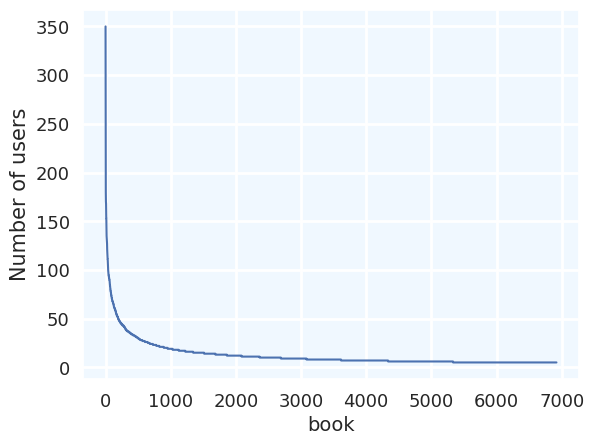

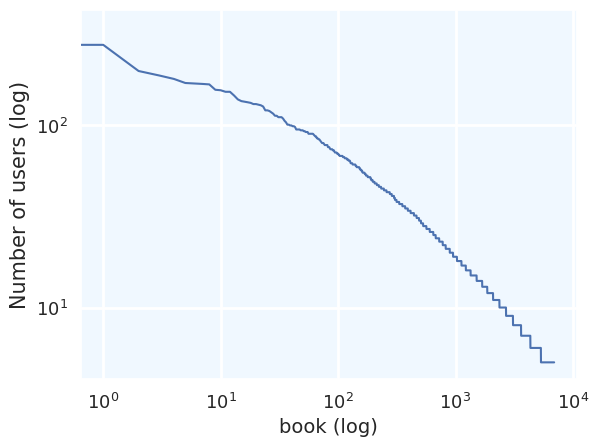

In [22]:
plot_data_distribution(item_dist, item_col)
plot_data_distribution(item_dist, item_col, [False, 0],True)

## E. Popularity in the data

In [23]:
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. items labeled as "popular": ' + str(len(top_item_dist)))

No. items labeled as "popular": 1384


In [24]:
def calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col):
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles
    i=0
    for u, df in df_events.groupby(user_col):
        no_user_items = len(set(df[item_col]))
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        user_pop_item_fraq = sum(item_dist[df[item_col]] / num_users) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq)
        i+=1
        if i%1000==0:
            print(i)
    return pop_count,user_hist,pop_fraq, pop_item_fraq

In [25]:
pop_count,user_hist,pop_fraq, pop_item_fraq = calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col)

1000
2000
3000
4000
5000
6000


In [26]:
def plot_popularity_distribution(pop_fraq, item_col, dividing = [False,0]):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        y = range(len(pop_fraq))
        x0 = int(len(y)*dividing[1]) 
        x1 = int(len(y)*(1-dividing[1]))
        x= sorted(pop_fraq)
        plt.plot(y[:x0+1],x[:x0+1], label="Niche users", linewidth = 5)
        plt.plot(y[x0:x1+1],x[x0:x1+1], label = "Diverse users", linewidth = 5)
        plt.plot(y[x1:],x[x1:], label = "BestSeller users", linewidth =5)
    else:
        plt.plot(sorted(pop_fraq))
    plt.xlabel('User', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel('Ratio of popular '+item_col+'s', fontsize='15')
    plt.yticks(fontsize='13')
    plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular '+item_col+'s')
    plt.legend(fontsize='15')
    plt.show(block=True)

def plot_profile_size_vs_popularity(pop_metric, user_hist, way, item_col):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_metric)
    print('R-value: ' + str(r_value))
    line = slope * np.array(user_hist) + intercept
    plt.plot(user_hist, pop_metric, 'o', user_hist, line)
    plt.xlabel('User profile size', fontsize='15')
    plt.xticks(fontsize='13')
    if way == "count":
        ylabel = "Number of popular "+item_col+"s"
    elif way == "percentage":
        ylabel = 'Percentage of popular '+item_col+'s'
    else:
        ylabel = "Average popularity of "+item_col+"s"
    plt.ylabel(ylabel, fontsize='15')
    plt.yticks(fontsize='13')
    plt.show(block=True)

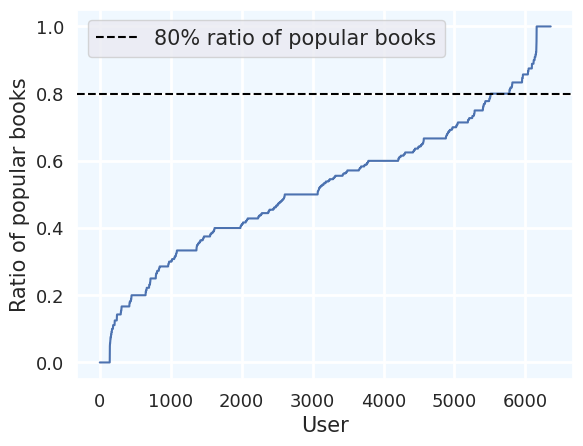

R-value: 0.923043590336


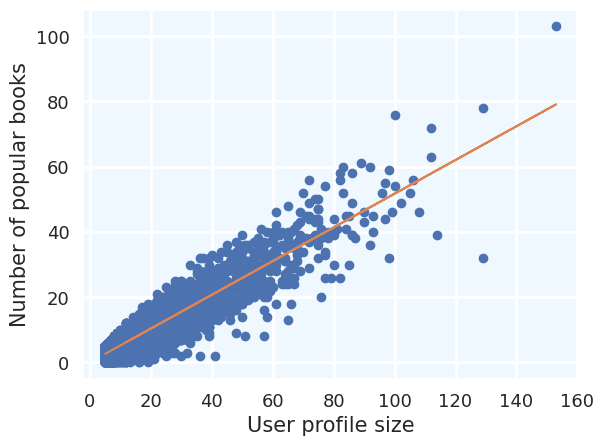

R-value: -0.013155544625724313


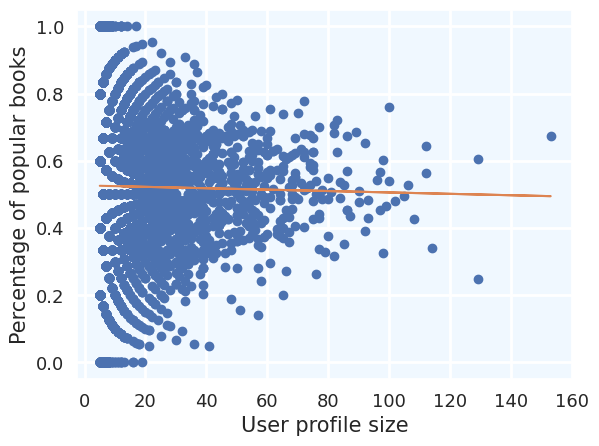

R-value: -0.033575222226251665


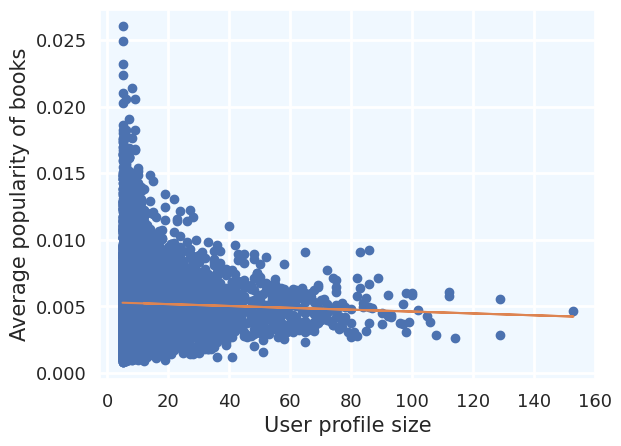

In [27]:
plot_popularity_distribution(pop_fraq, item_col)
plot_profile_size_vs_popularity(pop_count,user_hist, "count", item_col)
plot_profile_size_vs_popularity(pop_fraq,user_hist, "percentage", item_col)
plot_profile_size_vs_popularity(pop_item_fraq,user_hist, "average", item_col)

## F. User groups

In [28]:
def sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = "pop_fraq"):
    user_dist = user_dist.sort_index()
    user_dist_sorted = pd.DataFrame(data = user_dist)
    
    user_dist_sorted.columns = ["count"]
    
    user_dist_sorted["pop_count"] = pop_count
    user_dist_sorted["user_hist"] = user_hist
    user_dist_sorted["pop_fraq"] = pop_fraq
    user_dist_sorted["pop_item_fraq"] = pop_item_fraq
    
    user_dist_sorted = user_dist_sorted.sort_values(by=[by])
    return user_dist_sorted

def split(user_dist_sorted, top_fraction):
    low, med, high = np.split(user_dist_sorted, [int(top_fraction*len(user_dist_sorted)), int((1-top_fraction)*len(user_dist_sorted))])
    return low, med, high
def calculate_group_characteristics(low, med, high):
    low_profile_size = low.user_hist.mean()
    med_profile_size = med.user_hist.mean()
    high_profile_size = high.user_hist.mean()
    
    low_nr_users = len(low)
    med_nr_users = len(med)
    high_nr_users = len(high)
    
    low_GAP = low.pop_item_fraq.mean()
    med_GAP = med.pop_item_fraq.mean()
    high_GAP = high.pop_item_fraq.mean()
    
    return low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP

### Make notion of popularity propensity choice
The reader has to manually choose how to divide the users into groups according to their propensity for popular items.

In [29]:
popularity_function = {'pop_one': "pop_fraq",
             'pop_two': "pop_item_fraq"}

In [30]:
pop_notion = "pop_two"

In [31]:
user_dist_sorted = sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = popularity_function[pop_notion])
low, med, high = split(user_dist_sorted, top_fraction)
low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP = calculate_group_characteristics(low, med, high)

In [32]:
print('Niche GAP: ' + str(low_GAP))
print('Diverse GAP: ' + str(med_GAP))
print('BestSeller GAP: ' + str(high_GAP))

Niche GAP: 0.0020793485971879627
Diverse GAP: 0.004746984354432404
BestSeller GAP: 0.009717753280533033


In [33]:
def plot_group_characteristics(low_nr, med_nr, high_nr, way, item_col):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.bar(np.arange(3), [low_nr, med_nr, high_nr])
    plt.xticks(np.arange(3), ['Niche', 'Diverse', 'BestSeller'])
    plt.xlabel('User group')
    if way=="size":
        ylabel = 'Average user profile size'
    else:
        ylabel = "Number of users per group"
    plt.ylabel(ylabel)
    
    print('Niche: ' + str(low_nr))
    print('Diverse: ' + str(med_nr))
    print('BestSeller: ' + str(high_nr))
    plt.show(block=True)

Niche: 1271
Diverse: 3815
BestSeller: 1272


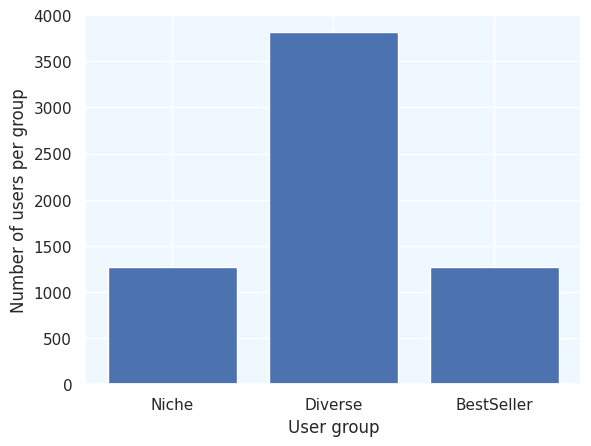

Niche: 9.892210857592447
Diverse: 16.300917431192662
BestSeller: 10.841981132075471


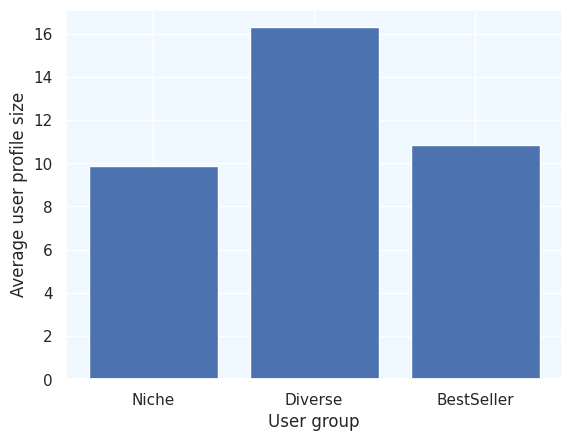

In [34]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users, way = "number", item_col = item_col)
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size, way = "size", item_col = item_col)

In [35]:
# plot_data_distribution(item_dist, item_col, dividing = [True, top_fraction], log = False)
# plot_popularity_distribution(pop_fraq, item_col, dividing = [True,top_fraction])

## G. Recommendation

In [36]:
df_events.head()

,user,book,rating
182,276847,3426029553,8
210,276847,3551551677,10
211,276847,3551551685,10
212,276847,3551551693,10
213,276847,3551551936,10


### G.1 Cornac
The library used by the book paper. It contains many algorithms.

In [37]:
df_events_cornac = df_events.copy()
mapping_dict = {} # Create a dictionary that maps each ISBN to an integer.
i=0
for book in df_events_cornac[item_col].unique():
    mapping_dict[book] = i
    i+=1
df_events_cornac[item_col] = df_events_cornac[item_col].map(lambda x: mapping_dict.get(x,x)) # Map in the ratings file

In [38]:
df_events_cornac.user = df_events_cornac.user.astype("string")
df_events_cornac[item_col] = df_events_cornac[item_col].astype("string")

In [39]:
df_item_dist_cornac = df_item_dist.rename(index = mapping_dict)

In [40]:
data = list(df_events_cornac[[user_col,item_col,predict_col]].to_records(index = False))

In [41]:
data[:3]

[('276847', '0', 8), ('276847', '1', 10), ('276847', '2', 10)]

In [42]:
# Split the data based on ratio
rs = RatioSplit(data=data, test_size=test_size, rating_threshold=rating_threshold, seed=123)

In [43]:
all_items = set(range(rs.total_items)) # needed for later

In [44]:
# Define the two different options for UserKNN, with and without mean centering
usKNN = UserKNN(k=40, similarity = 'cosine', mean_centered=False, seed = my_seed, verbose=True)
usKNN_means = UserKNN(k=40, similarity = 'cosine', mean_centered=True, seed = my_seed, verbose=True)

#### Training

In [45]:
# initialize models, here we are comparing: simple, traditional, and neural networks based models
models = [
          # 1: Random
          # 2: MostPop
          MostPop(),
          # 3: UserKNN
          usKNN,
          # 4: ItemKNN
          # ItemKNN(k=40, similarity = 'cosine', mean_centered=False, seed = my_seed, verbose=True),
          # # 5: UserKNN with means
          # usKNN_means,
          # ## 6: BaselineOnly
          # #BaselineOnly(verbose=True),
          # # 7: BPR
          # BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123, verbose=True),
          # # 8: MF
          # MF(k=30, max_iter=100, learning_rate=0.01, lambda_reg=0.001, seed=123, verbose=True),
          # # 9: PMF
          # PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001, verbose=True),
          # # 10: NMF
          # CornacNMF(k=15, max_iter=50, learning_rate=0.005, lambda_u=0.06, lambda_v=0.06, lambda_bu=0.02, lambda_bi=0.02, use_bias=False, verbose=True, seed=123),
          # # 11: WMF
          # WMF(k=50, max_iter=50, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01, verbose=True, seed=123),
          # # 12: PF
          # HPF(k=50, seed=123, hierarchical=False, name="PF", verbose=True),
          # # 13: NueMF
          # NeuMF(num_factors=8, layers=[32, 16, 8], act_fn="tanh", num_epochs=1, num_neg=3, batch_size=256, lr=0.001, seed=42, verbose=True),
          # # 14: VAECF
          # VAECF(k=10, autoencoder_structure=[20], act_fn="tanh", likelihood="mult", n_epochs=100, batch_size=100, learning_rate=0.001, beta=1.0, seed=123, use_gpu=True, verbose=True)
          ]

In [46]:
algo_names = ["Random",
              "MostPop", 
              "UserKNN",
              # "ItemKNN", 
              # "UserKNN with means", 
              # "BPR",
              # "MF",
              # "PMF",
              # "NMF",
              # "WMF",
              # "HPF",
              # "NeuMF",
              # "VAECF"
              ] # in the order that they are in the model list

In [47]:
# define metrics to evaluate the models
metrics = [MAE()]

# put it together in an experiment, voilà!
start = time.time()
exp = cornac.Experiment(eval_method=rs, models=models, metrics=metrics, user_based=True)
exp.run()
end = time.time()
print(round(end-start), "seconds.")

  0%|          | 0/6358 [00:00<?, ?it/s]


TEST:
...
        |    MAE | Train (s) | Test (s)
------- + ------ + --------- + --------
MostPop | 2.5096 |    0.0059 |   0.9190
UserKNN | 1.3491 |    0.6610 |   2.9839

5 seconds.


#### Ranking and recommendation
We have identified three evaluation strategies:
1. For every user in the **train set** rank **all items**. | Book paper, *eva_one*
2. For every user in the **test set** rank **only the items this user has rated in the test set**. | Music paper, *eva_two*
3. For every user in the **test set** rank **only the items this user has NOT rated in the train set**. | Movie(?) paper, *eva_three*

For every evaluation strategy, we define a function that recommends the appropriate items to the appropriate users as described above. 

##### Functions

In [48]:
def get_top_n_eva_one(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)
  for uid in tqdm(model.train_set.uid_map.values()): # every user in the train set
    user_id = list(model.train_set.user_ids)[uid] # so this is the actual user_id
    item_rank = model.rank(user_idx=uid)[0] # all
    # collect top N items
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [49]:
def get_top_n_eva_two(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)
  for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
    user_id = list(rs.train_set.user_ids)[uid]
    user_items_in_the_test_set = rs.test_set.user_data[uid][0] 
    
    item_rank = model.rank(user_idx=uid, item_indices = user_items_in_the_test_set)[0] # items the user has rated in the test set 
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [50]:
def get_top_n_eva_three(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)

  for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
    user_id = list(rs.train_set.user_ids)[uid]
    user_items_in_the_train_set = set(rs.train_set.user_data[uid][0])
    user_items_not_in_the_train_set = list(all_items.difference(user_items_in_the_train_set))
    
    item_rank = model.rank(user_idx=uid, item_indices = user_items_not_in_the_train_set)[0] # items the user has NOT rated in the TRAIN set
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [51]:
# random recommendation algorithm, same for every strategy 
def get_top_n_random(n=10):
    print("Random model is selected:")
    top_n = defaultdict(list)

    for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
      if uid not in top_n.keys():
        user_id = list(rs.train_set.user_ids)[uid]
        user_items_in_the_train_set = set(rs.train_set.user_data[uid][0])
        user_items_not_in_the_train_set = list(all_items.difference(user_items_in_the_train_set)) # random choice out of the items that the user has NOT rated in the train set
        for i in range(0, n):
          top_n[int(user_id)].append((int(rd.choice(user_items_not_in_the_train_set)), i))
          
    return top_n

##### Recommendation

Choose evaluation strategy.

In [49]:
evaluation_function = {'eva_one':get_top_n_eva_one,
             'eva_two': get_top_n_eva_two,
             'eva_three': get_top_n_eva_three}

In [50]:
choice = 'eva_two'
# to be manually set!!! 

### Prediction
Run it when different evaluation strategy is chosen.

In [52]:
algo_dict = {}
for i in range(0, len(algo_names)):
    if algo_names[i] == 'Random':
      top_n = get_top_n_random(n=10)
    else:
      top_n = evaluation_function[choice](algo_names[i],i-1, n=10)
    algo_dict[algo_names[i]] = top_n.items()

Random model is selected:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [00:03<00:00, 1573.08it/s]


MostPop model is selected:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [00:15<00:00, 356.93it/s]


UserKNN model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [02:28<00:00, 36.32it/s]


ItemKNN model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [02:57<00:00, 30.38it/s]


UserKNN with means model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [02:28<00:00, 36.42it/s]


BPR model is selected:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [00:27<00:00, 197.49it/s]


MF model is selected:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [00:27<00:00, 194.76it/s]


PMF model is selected:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [00:15<00:00, 339.32it/s]


NMF model is selected:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [00:28<00:00, 191.66it/s]


WMF model is selected:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [00:18<00:00, 299.18it/s]


HPF model is selected:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [00:24<00:00, 220.23it/s]


NeuMF model is selected:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [00:43<00:00, 123.43it/s]


VAECF model is selected:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [00:34<00:00, 154.88it/s]


### Evaluation
Run it when different popularity notion is chosen.

In [83]:
def calculate_RMSE_per_group(algo_name,i):
    model = exp.models[i]
    print(algo_name + " model is selected:")
    
    rmse_low = 0.0
    rmse_med = 0.0
    rmse_high = 0.0
    
    nr_low = 0.0
    nr_med = 0.0
    nr_high = 0.0
    
    for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
        user_id = list(rs.train_set.user_ids)[uid]
        user_items_in_the_test_set = rs.test_set.user_data[uid][0]
        item_ids = [list(model.train_set.item_ids)[test_item] for test_item in user_items_in_the_test_set]
        real_scores = df_events_cornac[(df_events_cornac.user==user_id)&(df_events_cornac[item_col].isin(item_ids))]['rating'].values
        pred_scores = []
        j=0
        for test_item in user_items_in_the_test_set:
            item_score = model.score(user_idx=uid, item_idx=test_item)
            pred_scores.append(item_score)

        user_rmse = mean_squared_error(real_scores, pred_scores, squared=False)
        
        if int(user_id) in low.index: # some issue with string vs integer
            rmse_low+=user_rmse
            nr_low += 1
        elif int(user_id) in med.index:
            rmse_med+=user_rmse
            nr_med += 1
        elif int(user_id) in high.index:
            rmse_high+=user_rmse
            nr_high += 1
        else:
          print("hi")
        j+=1
    rmse_low/=nr_low
    rmse_med/=nr_med
    rmse_high/=nr_high
    return rmse_low, rmse_med, rmse_high

In [100]:
RMSEs = pd.DataFrame(index = algo_names, columns = ['low','med','high']).fillna(0.0)

In [101]:
for i in range(0, len(algo_names)):
    RMSEs.loc[algo_names[i]] = calculate_RMSE_per_group(algo_names[i], i-1)

Random model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [01:23<00:00, 64.28it/s]


MostPop model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [01:14<00:00, 72.01it/s]


UserKNN model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [01:17<00:00, 69.48it/s]


In [102]:
RMSEs

,low,med,high
Random,1.43127741,1.61229848,1.55905295
MostPop,6.70198632,22.67569334,52.05898275
UserKNN,1.43127741,1.61229848,1.55905295


In [53]:
start = time.time()
i = 0
low_rec_gap_list = [] # one entry per algorithm
medium_rec_gap_list = []
high_rec_gap_list = []

for i in range(0, len(algo_names)):
    
    df_item_dist_cornac[algo_names[i]] = 0
    
    low_rec_gap = 0
    medium_rec_gap = 0
    high_rec_gap = 0
    
    low_count = 0
    med_count = 0
    high_count = 0

    top = algo_dict[algo_names[i]]
    for uid, user_ratings in tqdm(top):
        iid_list = []
        for (iid, _) in user_ratings:
            df_item_dist_cornac.loc[iid, algo_names[i]] += 1
            iid_list.append(iid)
        gap = sum(df_item_dist_cornac["count"].loc[iid_list]) / len(iid_list)
        if uid in low.index:
            low_rec_gap += gap
            low_count += 1
        elif uid in med.index:
            medium_rec_gap += gap
            med_count += 1
        elif uid in high.index:
            high_rec_gap += gap
            high_count += 1
        else:
          print("hi")
    low_rec_gap_list.append(low_rec_gap / low_count)
    medium_rec_gap_list.append(medium_rec_gap / med_count)
    high_rec_gap_list.append(high_rec_gap / high_count)
    i += 1 # next algorithm
end = time.time()
print(round(end-start), "seconds.")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [00:04<00:00, 1319.00it/s]

58 seconds.


### Cornac results.

In [54]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algo_names)):
    low_gap_vals.append((low_rec_gap_list[i] - low_GAP) / low_GAP * 100)
    medium_gap_vals.append((medium_rec_gap_list[i] - med_GAP) / med_GAP * 100)
    high_gap_vals.append((high_rec_gap_list[i] - high_GAP) / high_GAP * 100)

# Save!!

In [63]:
location = 'results/'
df_item_dist_cornac.to_csv(location+'df_item_dist_cornac_books_'+choice+'.csv') 
with open(location+'low_gap_vals_books_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(low_gap_vals, handle)
with open(location+'med_gap_vals_books_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(medium_gap_vals, handle)
with open(location+'high_gap_vals_books_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(high_gap_vals, handle)

# Test accuracy

In [79]:
import math

In [82]:
def calculate_RMSE_per_group(algo_name,i):
    model = exp.models[i]
    print(algo_name + " model is selected:")
    
    rmse_low = 0.0
    rmse_med = 0.0
    rmse_high = 0.0
    
    nr_low = 0.0
    nr_med = 0.0
    nr_high = 0.0
    
    for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
        user_id = list(rs.train_set.user_ids)[uid]
        user_items_in_the_test_set = rs.test_set.user_data[uid][0]
        item_ids = [list(model.train_set.item_ids)[test_item] for test_item in user_items_in_the_test_set]
        real_scores = df_events_cornac[(df_events_cornac.user==user_id)&(df_events_cornac[item_col].isin(item_ids))]['rating'].values
        pred_scores = []
        j=0
        for test_item in user_items_in_the_test_set:
            item_score = model.score(user_idx=uid, item_idx=test_item)
            pred_scores.append(item_score)

        user_rmse = mean_squared_error(real_scores, pred_scores, squared=False)
        
        if int(user_id) in low.index: # some issue with string vs integer
            rmse_low+=user_rmse
            nr_low += 1
        elif int(user_id) in med.index:
            rmse_med+=user_rmse
            nr_med += 1
        elif int(user_id) in high.index:
            rmse_high+=user_rmse
            nr_high += 1
        else:
          print("hi")
        j+=1
    rmse_low/=nr_low
    rmse_med/=nr_med
    rmse_high/=nr_high
    return rmse_low, rmse_med, rmse_high

In [81]:
calculate_RMSE_per_group('UserKNN', 1)

UserKNN model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5394/5394 [01:19<00:00, 67.92it/s]


(1.4312774098617038, 1.6122984809952992, 1.559052953661627)